# Project Description
Write up - https://www.joepeirson.co.uk/blog/neural-networks-drought

#### <u>Objective</u>
For this project I look at trying to predict the percentage of a state that will experience an exceptional drought a week in advance.
#### <u>Data</u>
I have used Data taken from the United States Drought Monitor website. Which can be found here -  https://droughtmonitor.unl.edu/Data/DataDownload/ComprehensiveStatistics.aspx <br>
I have used data from 1st Jan 2011 to 1st Jan 2021, using a state by state spatial scale, with the measurement for drought being percent of state area. There are five levels of drought severity, with D4 being the worse. The results are not culmative, therefore D0+D1+D2+D3+D4=100%. <br>
I have only chosen to use states that have at least a low level of severe drought severity. This has been done by only choosing states that have had a weekly average of D4 levels of drought which are higher than 1% of the states land area.

<img src="drought_data_types.png" width=600>

#### <u>Modelling</u>
I will use Neural Networks to build an algorithm. My dependant variable is the D4 metric for the current week, my independent variables are the D4 metrics for the past 8 weeks. <br>
The algorithm essentially predicts this weeks D4 level by using the D4 levels of the past 8 weeks.

# Load libraries and load/clean dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from math import floor
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 500)

In [2]:
def get_prev_week(df,code,date,days_back):
    df_week = df.loc[(df['StateAbbreviation']==code) &
           (df['ValidStart']==pd.to_datetime(date) - timedelta(days=days_back))].reset_index().iloc[:,1:]
    df_week = float(df_week[['D4']].mean())
    return df_week

In [3]:
df = pd.read_csv('/Users/joepeirson/Downloads/weather_data.csv')
df[['None', 'D0', 'D1', 'D2', 'D3', 'D4']] = df[['None', 'D0', 'D1', 'D2', 'D3', 'D4']]/100
states_affected = df.groupby('StateAbbreviation')['D4'].max().reset_index()
chosen_states = states_affected.loc[states_affected['D4']>.1]['StateAbbreviation'].to_list()
print('States used:',chosen_states)
df = df.loc[df['StateAbbreviation'].isin(chosen_states)].reset_index().iloc[:,1:]
df = df.drop(['MapDate','StatisticFormatID','ValidEnd'],1)
df['ValidStart'] = pd.to_datetime(df['ValidStart'])
df['prev_week1'] = df.apply(lambda x: get_prev_week(df,x['StateAbbreviation'],x['ValidStart'],7),axis=1)
df['prev_week2'] = df.apply(lambda x: get_prev_week(df,x['StateAbbreviation'],x['ValidStart'],14),axis=1)
df['prev_week3'] = df.apply(lambda x: get_prev_week(df,x['StateAbbreviation'],x['ValidStart'],21),axis=1)
df['prev_week4'] = df.apply(lambda x: get_prev_week(df,x['StateAbbreviation'],x['ValidStart'],28),axis=1)
df['prev_week5'] = df.apply(lambda x: get_prev_week(df,x['StateAbbreviation'],x['ValidStart'],35),axis=1)
df['prev_week6'] = df.apply(lambda x: get_prev_week(df,x['StateAbbreviation'],x['ValidStart'],42),axis=1)
df['prev_week7'] = df.apply(lambda x: get_prev_week(df,x['StateAbbreviation'],x['ValidStart'],49),axis=1)
df['prev_week8'] = df.apply(lambda x: get_prev_week(df,x['StateAbbreviation'],x['ValidStart'],56),axis=1)
df_new = df.loc[df['ValidStart']>='2020-01-01 00:00:00']
df = df.loc[df['ValidStart']<'2020-01-01 00:00:00']
print('Start Date:',min(df['ValidStart']),'\nEnd Date:',max(df['ValidStart']))

States used: ['AL', 'AR', 'AZ', 'CA', 'CO', 'FL', 'GA', 'IN', 'KS', 'KY', 'LA', 'MO', 'MT', 'NE', 'NM', 'NV', 'OK', 'SC', 'SD', 'TN', 'TX', 'UT', 'WY']
Start Date: 2009-12-29 00:00:00 
End Date: 2019-12-31 00:00:00


In [4]:
df = df.dropna()
# this drops the rows where there were not 8 previous weeks of data available

# Visualizing the Dataset

The below graphic shows different states varying D4 (exceptional drought) levels. I have taken out the recordings of when the D4 level was zero to help give the graph clarity.<br>
From the graphic it is clear that D4 levels quickly spike and then quickly fall again. The task of the algorithm is then to be able to quickly spot these spikes and falls. 

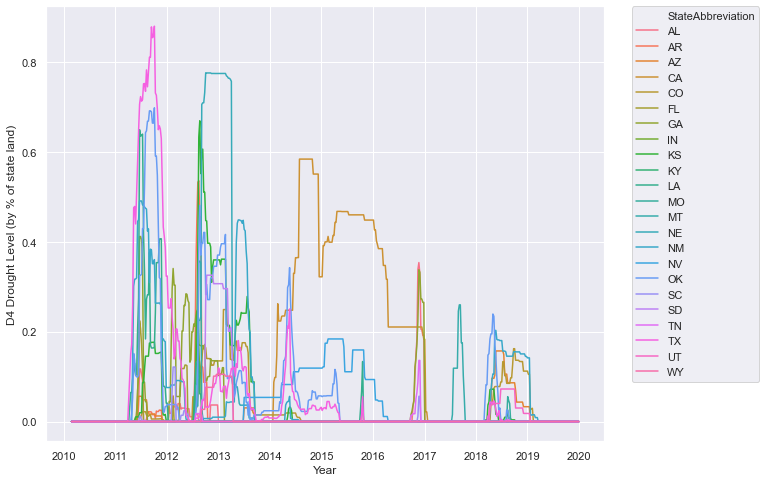

In [5]:
df_graph = df.loc[df['D4']>=0]
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.lineplot(data=df_graph, x='ValidStart', y='D4', 
                     hue='StateAbbreviation')
plt.ylabel('D4 Drought Level (by % of state land)')
plt.xlabel('Year')
# ax.set(xlim=(pd.Timestamp('2010-01-01 00:00:00'),pd.Timestamp('2020-01-01 00:00:00')))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Index(['StateAbbreviation', 'None', 'D0', 'D1', 'D2', 'D3', 'D4', 'ValidStart',
       'prev_week1', 'prev_week2', 'prev_week3', 'prev_week4', 'prev_week5',
       'prev_week6', 'prev_week7', 'prev_week8'],
      dtype='object')

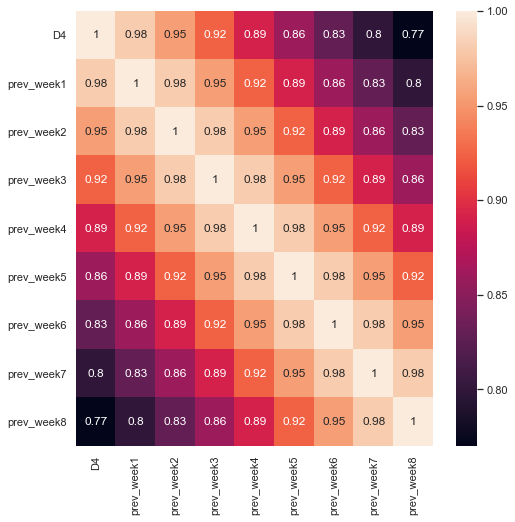

In [6]:
# This shows how each variable correlates with each other
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(df[['StateAbbreviation','D4', 'ValidStart',
       'prev_week1', 'prev_week2', 'prev_week3', 'prev_week4', 'prev_week5',
       'prev_week6', 'prev_week7', 'prev_week8']].corr(), annot = True)
df.columns

In [7]:
df_regr = df.drop(['StateAbbreviation', 'None', 'D0', 'D1', 'D2', 'D3', 'ValidStart'],1)
df_regr.columns

Index(['D4', 'prev_week1', 'prev_week2', 'prev_week3', 'prev_week4',
       'prev_week5', 'prev_week6', 'prev_week7', 'prev_week8'],
      dtype='object')

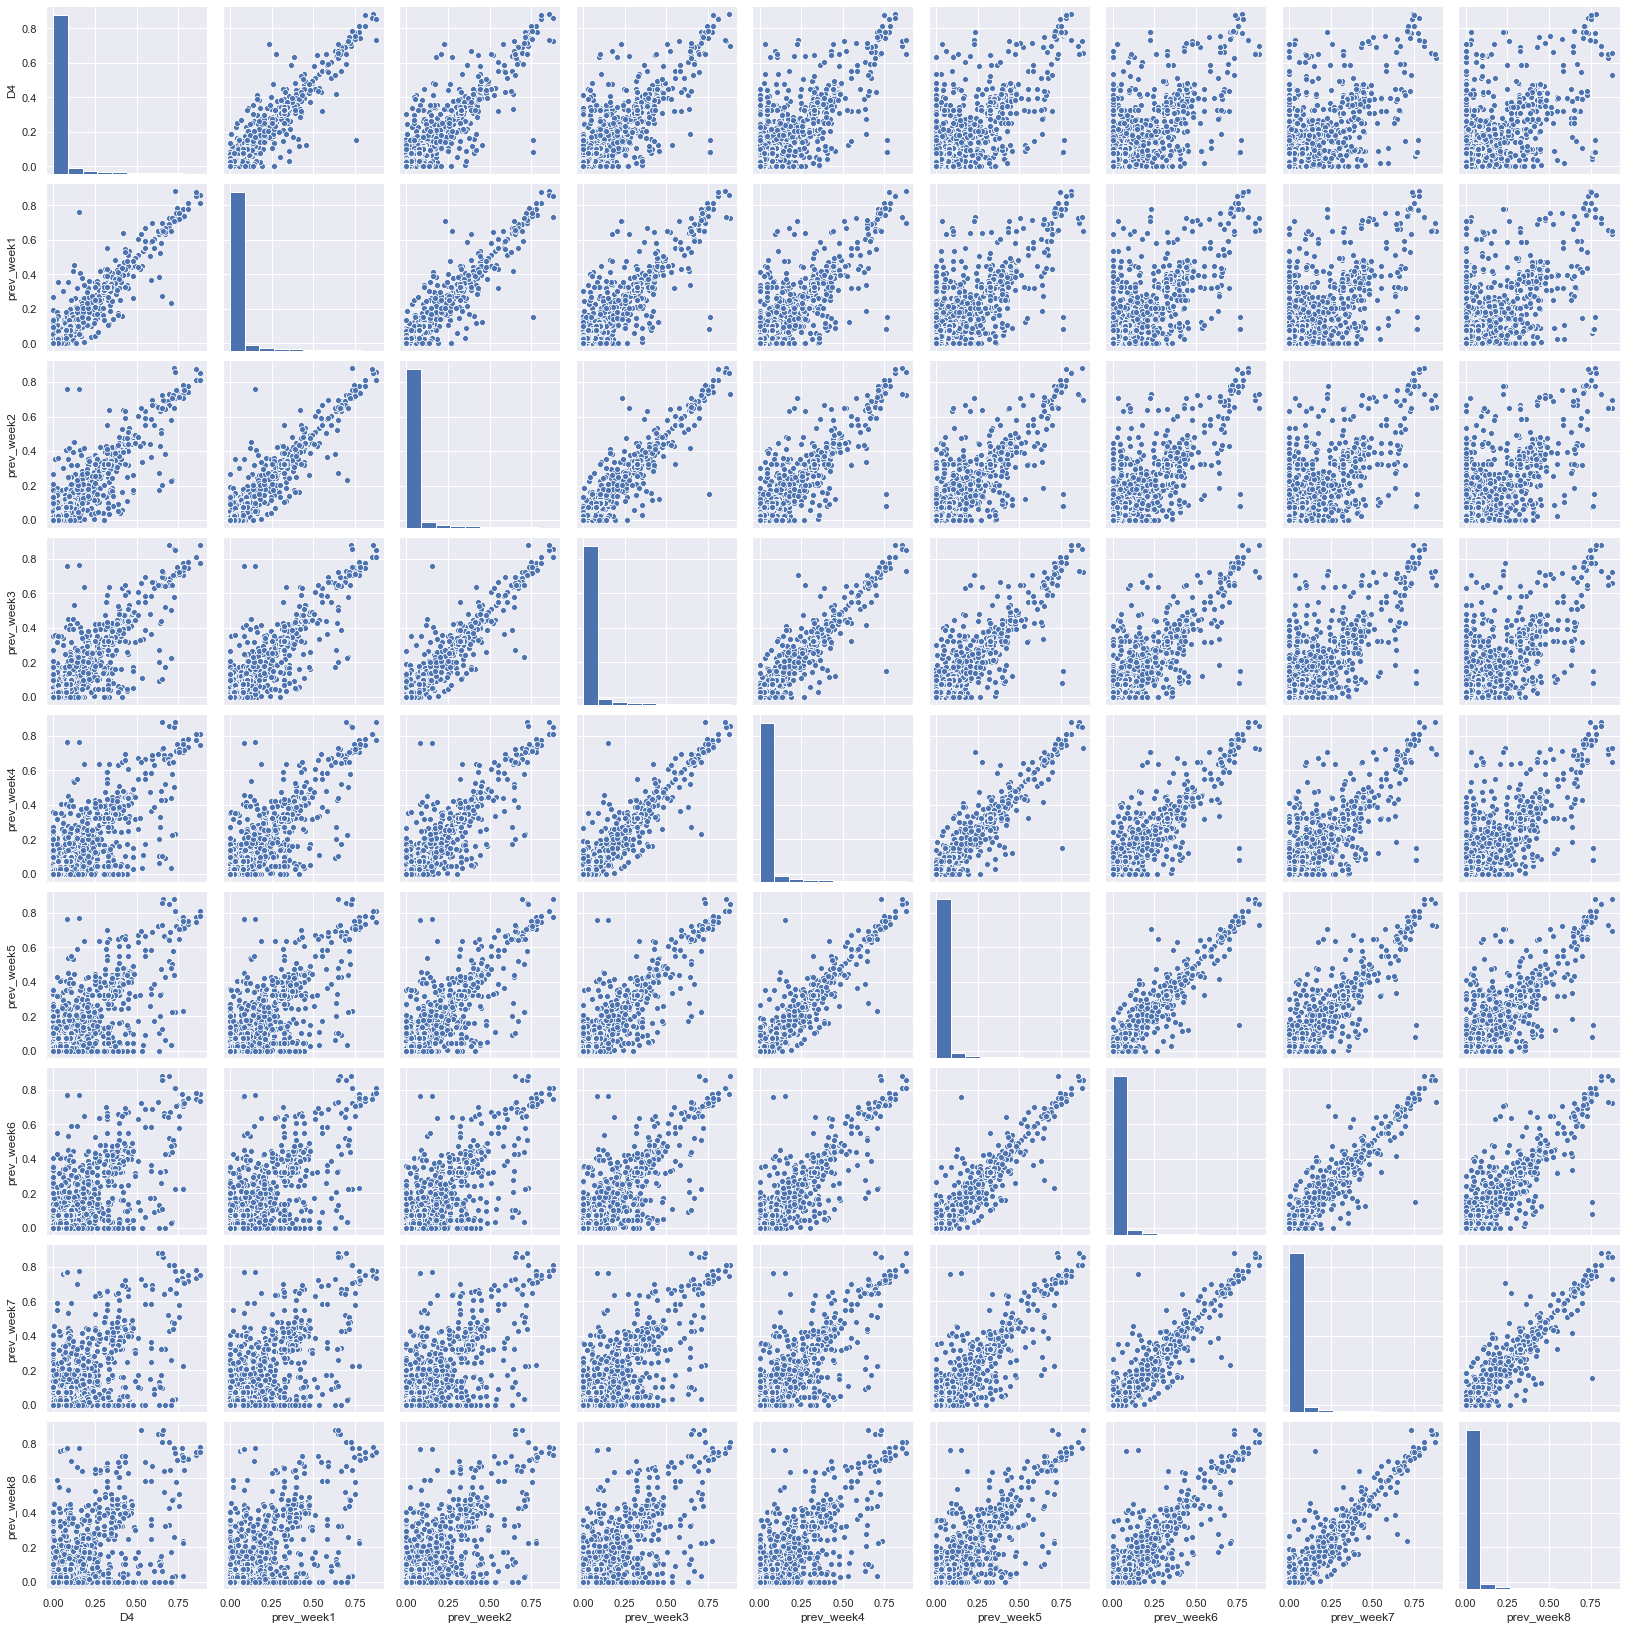

In [8]:
sns.pairplot(df_regr)

# Scale Data

In [9]:
X = df_regr.drop('D4',axis=1)
y = df_regr['D4']

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
y = y.values.reshape(-1,1)

In [12]:
y_scaled = scaler.fit_transform(y)

# Train and Test Model

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.2)

In [14]:
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(50, input_dim = 8, activation = 'relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                450       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 3,051
Trainable params: 3,051
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = 'Adam', loss ='mean_squared_error')

In [17]:
epochs_hist = model.fit(X_train, y_train, epochs = 100, 
                        batch_size = 500, validation_split= .2)

Epoch 1/100
16/16 [==============================] - 1s 43ms/step - loss: 0.0070 - val_loss: 0.0011
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 7.6824e-04
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 8.9293e-04 - val_loss: 5.5098e-04
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 7.1122e-04 - val_loss: 4.8605e-04
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 5.7570e-04 - val_loss: 4.6604e-04
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 4.8329e-04 - val_loss: 4.3929e-04
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 5.0906e-04 - val_loss: 4.1245e-04
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 4.4212e-04 - val_loss: 4.0508e-04
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 4.6900e-04 - val_loss: 3.9587e-04
Epoch 10/100
16/16 [============================

16/16 [==============================] - 0s 3ms/step - loss: 2.9583e-04 - val_loss: 3.7241e-04
Epoch 78/100
16/16 [==============================] - 0s 3ms/step - loss: 2.7698e-04 - val_loss: 3.7074e-04
Epoch 79/100
16/16 [==============================] - 0s 3ms/step - loss: 4.2207e-04 - val_loss: 3.9731e-04
Epoch 80/100
16/16 [==============================] - 0s 3ms/step - loss: 3.9579e-04 - val_loss: 3.7263e-04
Epoch 81/100
16/16 [==============================] - 0s 3ms/step - loss: 3.8459e-04 - val_loss: 3.7139e-04
Epoch 82/100
16/16 [==============================] - 0s 3ms/step - loss: 3.5560e-04 - val_loss: 3.7064e-04
Epoch 83/100
16/16 [==============================] - 0s 3ms/step - loss: 3.8623e-04 - val_loss: 3.6866e-04
Epoch 84/100
16/16 [==============================] - 0s 3ms/step - loss: 3.3636e-04 - val_loss: 3.8752e-04
Epoch 85/100
16/16 [==============================] - 0s 3ms/step - loss: 3.4106e-04 - val_loss: 4.0223e-04
Epoch 86/100
16/16 [=====================

# Evaluate the Model

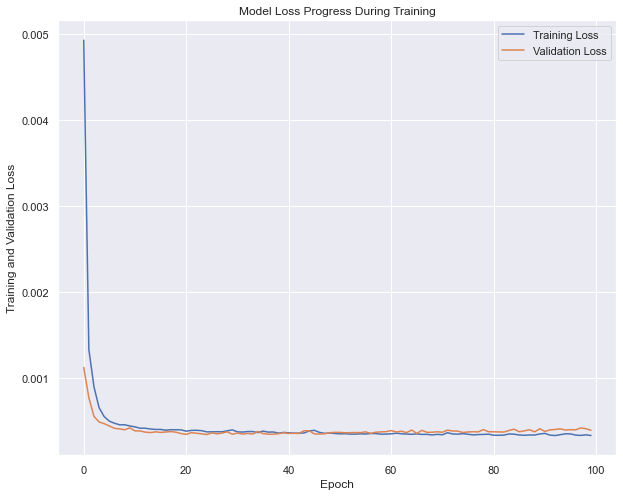

In [18]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])

In [19]:
y_predict = model.predict(X_test)

y_predict_orig = scaler.inverse_transform(y_predict)
y_test_orig = scaler.inverse_transform(y_test)

Text(0.5, 1.0, 'True Values vs Predicted Values')

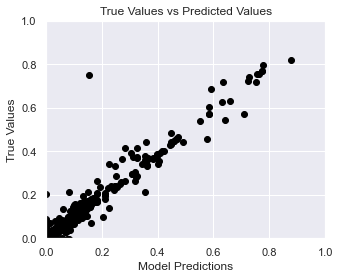

In [20]:
sns.set(rc={'figure.figsize':(5,4)})

plt.plot(y_test_orig, y_predict_orig, "o",color= 'black')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('True Values vs Predicted Values')

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)), '.3f'))
MSE =  round(mean_squared_error(y_test, y_predict),5)
MAE = round(mean_absolute_error(y_test, y_predict),5)
r2 = round(r2_score(y_test, y_predict),5)
adj_r2 = round(1-(1-r2)* (n-1)/(n-k-1),5)

print(f'RMSE:{RMSE}')
print(f'MSE:{MSE}')
print(f'MAE:{MAE}')
print(f'r2:{r2}')
print(f'adj_r2:{adj_r2}')

RMSE:0.02
MSE:0.00042
MAE:0.00504
r2:0.95717
adj_r2:0.95702


# Testing on New Data
Now the model has been built and looks fairly accurate, I can test it on new data. <br><br>
The next dataset is all the drought data from 2020. I have taken just those states that had a maximum D4 Drought level of above 1%, therefore only concentrating on those dates that are normally affected by droughts. 

In [22]:
df_new['predict'] = df_new.apply(lambda x:
                         scaler.inverse_transform(model.predict([[
                         x['prev_week1'],x['prev_week2'],x['prev_week3'],x['prev_week4'],
                         x['prev_week5'],x['prev_week6'],x['prev_week7'],x['prev_week8']]]))[0][0],axis=1)
df_new = df_new[['StateAbbreviation', 'D4', 'ValidStart','predict']]

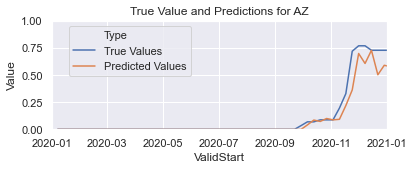

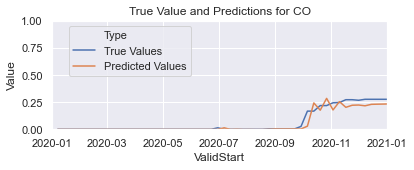

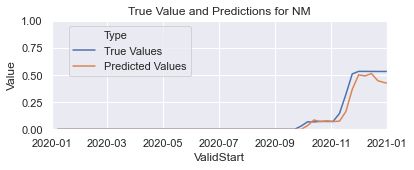

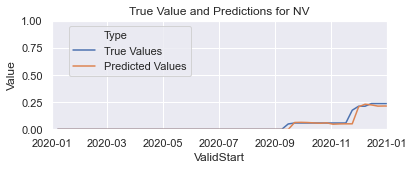

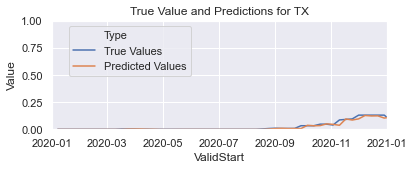

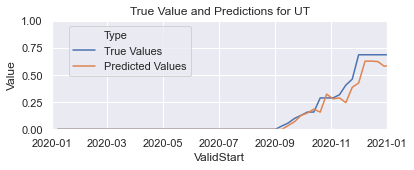

In [23]:
for state  in chosen_states:
    df_state = df_new.loc[df_new['StateAbbreviation']==state]
    if df_state['D4'].max()>.1: # Just get states with above a maximum of 1% drought
        df_true = df_state[['StateAbbreviation', 'D4', 'ValidStart']].rename(columns={'D4': 'Value'})
        df_true['Type'] = 'True Values'
        df_pred = df_state[['StateAbbreviation', 'predict', 'ValidStart']].rename(columns={'predict': 'Value'})
        df_pred['Type'] = 'Predicted Values'

        df_state1 = pd.concat([df_true,df_pred])

        sns.set(rc={'figure.figsize':(6,2)})
        ax = sns.lineplot(data=df_state1, x='ValidStart', y='Value', 
                             hue='Type')
        ax.set(xlim=(pd.Timestamp('2020-01-01 00:00:00'),pd.Timestamp('2021-01-01 00:00:00')))
        ax.set(ylim=(0,1))
        plt.legend(bbox_to_anchor=(.05, .95), loc=2, borderaxespad=0.)
        plt.title(f'True Value and Predictions for {state}')
        plt.show()

# Conclusions

The underlying metrics and the predictive quality of my models seems very high, but there are ways that it could possibly be improved. By using geospatial data like longitude and latitude data, I can see how a drought spreads and travels over land mass. I can also look at different types of droughts in terms of severity and length of time.

A big improvement would be if I looked at more granular data, then I could look at how specific areas in a state would be affected. My model only gives predictions on percentage drought across the state, but a more practical model would be able to look at which areas within a state are likely to be affected by a drought. 